@author: Valentin Larrieu


 INITIALISATION
Phy 1:  [ 0.84442185]
Phy 2:  [ 0.15557815]
Mu 1:  [[ 17.89772015]
 [  1.02857904]]
Mu 2:  [[ 17.89772015]
 [  1.02857904]]
Sigma 1:  [[ 3.31513478  2.7862462 ]
 [ 2.7862462   4.2721792 ]]
Sigma 2:  [[ 2.05591409  0.61853427]
 [ 0.61853427  2.24560312]]
[Loop] pXSachantZ1 : 0
[Loop] pXSachantZ2 : 0
[Loop] W1 SUM : 319.750082985
[Loop] W2 SUM : 280.249917015
[Loop] class w1 : [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1. 

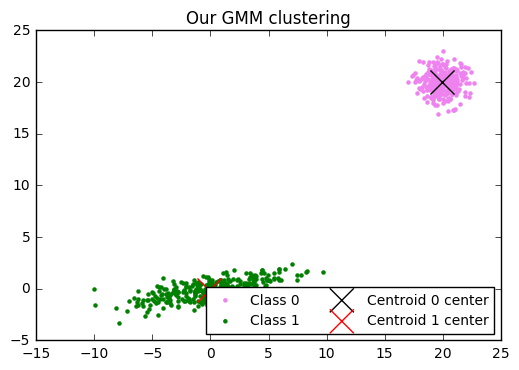

In [1]:
# We import the libraries we are going to use
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
import random
import math

n_samples_train = 300
# generate random sample, two components
np.random.seed(0)  # We fix the rng to have reproductible results
random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples_train, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples_train, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])
X_train = X_train.transpose()
# GMM : Here j=2, n=2, m=600

#we randomly set the variables
phy1 = np.array([random.uniform(0, 1)])
phy2 = 1 - phy1
mu1 = np.array([[random.uniform(-20, 30)], [random.uniform(-20, 30)]])
mu2 = np.array([[random.uniform(-20, 30)], [random.uniform(-20, 30)]])
sig1 = np.random.randn(2, 2)
sig1 = np.matmul(sig1.transpose(), sig1)  # We want a cov matrix so we do transpose of a times a
sig2 = np.random.randn(2, 2)
sig2 = np.matmul(sig2.transpose(), sig2)

print("\n INITIALISATION")
print("Phy 1: ", phy1)
print("Phy 2: ", phy2)
print("Mu 1: ", mu1)
print("Mu 2: ", mu1)
print("Sigma 1: ", sig1)
print("Sigma 2: ", sig2)

llt = 1
llt1 = 0
w1 = np.zeros(2 * n_samples_train)
w2 = np.zeros(2 * n_samples_train)
pXSachantZ1 = 0
pXSachantZ2 = 0

#the E_Step of the algorithm
def E_step(n_samples, X_train, mu1, mu2, sig1, sig2, phy1, phy2):
    for i in range(n_samples):
        pXSachantZ1 = math.exp((-1 / 2) * np.matmul((np.subtract(X_train[:, [i]], mu1)).transpose(),
                                                    np.matmul(np.linalg.inv(sig1),
                                                              np.subtract(X_train[:, [i]], mu1)))) / (
                      2 * math.pi * np.sqrt(np.linalg.det(sig1)))
        pXSachantZ2 = math.exp((-1 / 2) * np.matmul((np.subtract(X_train[:, [i]], mu2)).transpose(),
                                                    np.matmul(np.linalg.inv(sig2),
                                                              np.subtract(X_train[:, [i]], mu2)))) / (
                      2 * math.pi * np.sqrt(np.linalg.det(sig2)))
        w1[i] = (pXSachantZ1 * phy1) / (pXSachantZ1 * phy1 + pXSachantZ2 * phy2)
        w2[i] = (pXSachantZ2 * phy2) / (pXSachantZ1 * phy1 + pXSachantZ2 * phy2)
    return w1, w2

#the M_Step of the algorithm
def M_Step(n_samples, X_train, mu1, mu2, sig1, sig2, phy1, phy2):
    summu1 = 0
    summu2 = 0
    sumsig1 = 0
    sumsig2 = 0
    sumw1 = 0
    sumw2 = 0
    phy1 = w1.sum() / (n_samples)
    phy2 = w2.sum() / (n_samples)
    # we update the parameters
    for i in range(n_samples):
        summu1 = np.add(summu1, (w1[i] * X_train[:, [i]]))
        summu2 = np.add(summu2, (w2[i] * X_train[:, [i]]))
        sumsig1 = np.add(
            sumsig1,
            w1[i] * np.matmul(
                np.subtract(X_train[:, [i]], mu1),
                (np.subtract(X_train[:, [i]], mu1)).transpose()
            )
        )
        sumsig2 = np.add(sumsig2, (
            w2[i] * np.matmul(np.subtract(X_train[:, [i]], mu2), (np.subtract(X_train[:, [i]], mu2)).transpose())))
        sumw1 = sumw1 + w1[i]
        sumw2 = sumw2 + w2[i]

    mu1 = summu1 / (sumw1)
    mu2 = summu2 / (sumw2)
    sig1 = sumsig1 / (sumw1)
    sig2 = sumsig2 / (sumw2)
    return phy1, phy2, sig1, sig2, mu1, mu2

def compute_Likelihood(n_samples, X_train, mu1, mu2, sig1, sig2, phy1, phy2):
    sumllt = 0
    for i in range(n_samples):
        pXSachantZ1 = math.exp((-1 / 2) * np.matmul((np.subtract(X_train[:, [i]], mu1)).transpose(),
                                                    np.matmul(np.linalg.inv(sig1),
                                                              np.subtract(X_train[:, [i]], mu1)))) / (
                      2 * math.pi * np.sqrt(np.linalg.det(sig1)))
        pXSachantZ2 = math.exp((-1 / 2) * np.matmul((np.subtract(X_train[:, [i]], mu2)).transpose(),
                                                    np.matmul(np.linalg.inv(sig2),
                                                              np.subtract(X_train[:, [i]], mu2)))) / (
                      2 * math.pi * np.sqrt(np.linalg.det(sig2)))
        sumllt = sumllt + w1[i] * math.log((pXSachantZ1 * phy1) / w1[i]) + w2[i] * math.log(
            (pXSachantZ2 * phy2) / w2[i])
    llt = sumllt
    return llt

while (abs(llt - llt1) > 0.01):

    # E Step
    w1, w2 = E_step(2*n_samples_train, X_train, mu1, mu2, sig1, sig2, phy1, phy2)

    # We verify
    print("[Loop] pXSachantZ1 :", pXSachantZ1)
    print("[Loop] pXSachantZ2 :", pXSachantZ2)
    print("[Loop] W1 SUM :", w1.sum())
    print("[Loop] W2 SUM :", w2.sum())
    print("[Loop] class w1 :", np.around(w1))
    print("[Loop] class w2 :", np.around(w2))

    #M Step
    phy1,phy2,sig1,sig2,mu1,mu2=M_Step(2*n_samples_train, X_train, mu1, mu2, sig1, sig2, phy1, phy2)

    # evaluation of the log likelihood:
    llt1 = llt
    llt= compute_Likelihood(2*n_samples_train, X_train, mu1, mu2, sig1, sig2, phy1, phy2)


# End of loop

# Verification
print("\n AFTER GMM")
print("Phy 1: ", phy1)
print("Phy 2: ", phy2)
print("Mu 1: ", mu1)
print("Mu 2: ", mu1)
print("Sigma 1: ", sig1)
print("Sigma 2: ", sig2)
y_train=[np.around(w1),np.around(w2)]
print("Predicted class of train Set : ",y_train)


# We create a test dataset
X_test = C = np.array(
    [[10., -10., 0., 20., 17., 20.], [0., 0., 0., 23., 20., 18.]])  # We create test point : 3 for each cluster
print("TEST SET : ",X_test)
n_samples_test=6
w1 = np.zeros(n_samples_test)
w2 = np.zeros(n_samples_test)
# We use our model to cluster them
w1, w2 = E_step(n_samples_test, X_test, mu1, mu2, sig1, sig2, phy1, phy2)
y_test=[np.around(w1),np.around(w2)]
print("Predicted class of test Set : ",y_test )

n_samples_total=n_samples_test+2*n_samples_train
Y=np.concatenate((y_train,y_test),axis=1)
X=np.concatenate((X_train,X_test),axis=1)



# We plot the result
X_class0=np.array([[],[]])
X_class1=np.array([[],[]])

for i in range (n_samples_total):
    if Y[0,i]==1.:
        X_class0=np.concatenate((X_class0, X[:, [i]]), axis=1)
    else:
        X_class1 = np.concatenate((X_class1, X[:, [i]]), axis=1)


classOplot=plt.scatter(X_class0[0],X_class0[1],s=5,color="violet",marker="o")
class1plot=plt.scatter(X_class1[0],X_class1[1],s=5,color="green",marker="o")
mu0plot=plt.scatter(mu1[0],mu1[1],marker="x",color="black",s=300)
mu1plot=plt.scatter(mu2[0],mu2[1],marker="x",color="red",s=300)
plt.title("Our GMM clustering")

plt.legend((classOplot, class1plot, mu0plot, mu1plot),
           ('Class 0', 'Class 1', 'Centroid 0 center', 'Centroid 1 center'),
           scatterpoints=1,
           loc='lower right',
           ncol=2,
           fontsize=10)

plt.show()
